## 2.1 Prepare the Dataset
    First familiarise yourself with the dataset. It is included as a TensorFlow Dataset but can also be obtained from other sources. Try to understand how it works (information in the data, dataset size, image size, are there color channels, type the data is stored as, etc.). Understanding the data you are working with and applying respective preprocessing steps is a major part of the process for real life applications. Now that you familiarised yourself with it, load the data and apply respective preprocessing steps using a data pipeline (In case of problems refer to your old homework tasks or the Courseware). 1 Visualize a sample of the dataset.

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from tensorflow import keras
from keras import datasets, layers, models
import datetime
import tqdm

# Launch tensorboard session
%load_ext tensorboard

# Load cifar10 dataset
train_ds, test_ds = tfds.load('cifar10', split=['train','test'], as_supervised=True)
train_images, train_labels = [], []
test_images, test_labels = [], []

for images, labels in train_ds:
    train_images.append(images)
    train_labels.append(labels)
    
for images, labels in test_ds:
    test_images.append(images)
    test_labels.append(labels)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                    'dog', 'frog', 'horse', 'ship', 'truck']

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [4]:
# Create a data pipeline function that prepares data for use in the model
def prepare_cifar10_dataset(cifar10):
    # Convert data from uint8 to float32
    cifar10 = cifar10.map(lambda img, target: (tf.cast(img, tf.float32), target))
    # Sloppy input normalization, just bringing image values from range [0, 255] to [0, 1]
    cifar10 = cifar10.map(lambda img, target: ((img/128.), target))
    # Create one-hot targets
    cifar10 = cifar10.map(lambda img, target: (img, tf.one_hot(tf.cast(target, tf.int32), depth=10)))
    # Cache this progress in memory, as there is no need to redo it; it is deterministic after all
    cifar10 = cifar10.cache()
    # Shuffle data
    cifar10 = cifar10.shuffle(1000)
    # Batch data
    cifar10 = cifar10.batch(32)
    # Prefetch data
    cifar10 = cifar10.prefetch(20)
    # Return preprocessed dataset
    return cifar10

train_dataset = prepare_cifar10_dataset(train_ds) 
test_dataset = prepare_cifar10_dataset(test_ds)

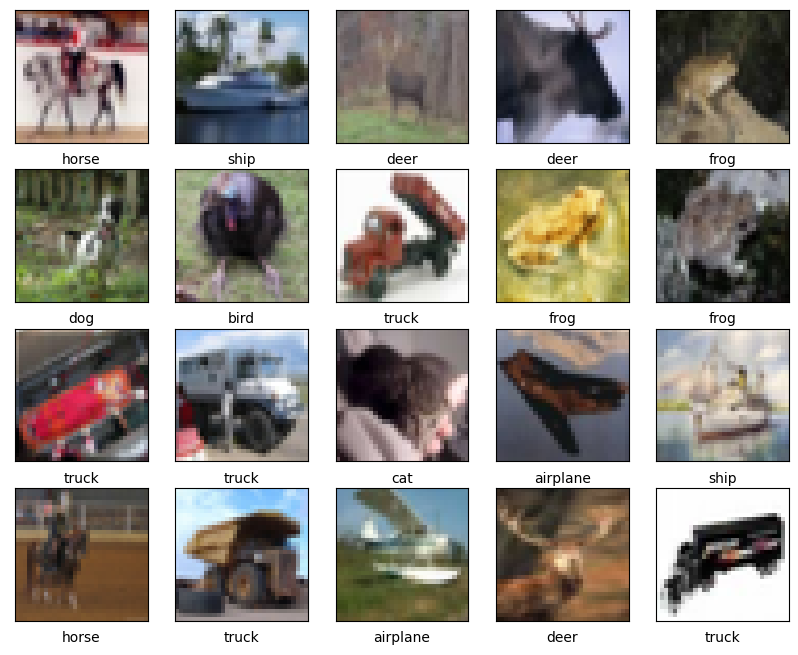

In [5]:
# Visualize sample images
def plot_the_images(train_images, train_labels, names):
    plt.figure(figsize=(10,10))
    for item in range(20):
        plt.subplot(5, 5, item+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(train_images[item])
        # The CIFAR labels happen to be arrays, 
        # which is why you need the extra index
        plt.xlabel(names[train_labels[item]])
    plt.show()

plot_the_images(train_images, train_labels, class_names)

## 2.2 The CNN Model
    Build a Convolutional Neural Network inspired by the information gained in this weeks Courseware. You are going to need more than the dense-layers used so far. Start with a basic structure and don’t necessarily think about optimizing the architecture too much, as this will be part of the last step. 

In [6]:
# Create basic convolutional neural netwotk class
class BasicCNN(tf.keras.Model):
    def __init__(self, optimizer, num_classes, input_layer_shape):
        super(BasicCNN, self).__init__()

        self.optimizer = optimizer
        self.num_classes = num_classes
        self.input_layer_shape = input_layer_shape
        self.loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
        self.metrics_list = [
            tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
            tf.keras.metrics.Mean(name='loss')    
        ] 

        self.dropout1 = tf.keras.layers.Dropout(0.25, input_shape=self.input_layer_shape)
        
        self.conv_layer1 = tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu')
        self.conv_layer2 = tf.keras.layers.Conv2D(32, 3, activation='relu')
        self.pooling = tf.keras.layers.MaxPooling2D((2,2))
        # Prevents overfitting
        self.dropout2 = tf.keras.layers.Dropout(0.25)

        self.conv_layer3 = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')
        self.conv_layer4 = tf.keras.layers.Conv2D(64, 3, activation='relu')
        self.avg_global_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.dropout3 = tf.keras.layers.Dropout(0.25)

        self.flatten = tf.keras.layers.Flatten()
        self.out_layer = tf.keras.layers.Dense(self.num_classes, activation='softmax')
        
    @tf.function
    def __call__(self, x, training=False):
        if training:
            x = self.dropout1(x, training=training)
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = self.pooling(x)
        if training:
            x = self.dropout2(x, training=training)
        x = self.conv_layer3(x)
        x = self.conv_layer4(x)
        x = self.avg_global_pool(x)
        if training:
            x = self.dropout3(x, training=training)
        x = self.flatten(x)
        x = self.out_layer(x)

        return x

    # Metrics property
    @property
    def metrics(self):
        return self.metrics_list
        # return a list with all metrics in the model

    # Reset all metrics objects
    def reset_metrics(self):
        for metric in self.metrics:
            metric.reset_states()

    # Train step method
    @tf.function
    def train_step(self, data):
        image, label = data

        with tf.GradientTape() as tape:
            output = self(image, training=True)
            loss = self.loss_function(label, output)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        # Update the state of the metrics according to loss
        self.metrics[0].update_state(label, output)
        self.metrics[1].update_state(loss)

        # Return a dictionary with metric names as keys and metric results as values
        return {m.name: m.result() for m in self.metrics}

    @tf.function
    def test_step(self, data):
        image, label = data

        # The same as train step(without parameter updates)
        output = self(image, training=True)
        loss = self.loss_function(label, output)

        # Update the state of the metrics according to loss
        self.metrics[0].update_state(label, output)
        self.metrics[1].update_state(loss)

        # Return a dictionary with metric names as keys and metric results as values
        return {m.name: m.result() for m in self.metrics}

## 2.3 Training the network
    Define a training loop function. Define your hyperparameters, think of an appropriate loss function and optimizer and initialize everything. Store loss and accuracy for training and test data. Training your network for a maximum of 15 epochs should be enough.

In [7]:
def create_summary_writers(optimizer_name):
    # Define where to save the logs
    # along with this, you may want to save a config file with the same name so you know what the hyperparameters were used
    # Alternatively make a copy of the code that is used for later reference
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    train_log_path = f"logs/{optimizer_name}/{current_time}/train"
    test_log_path = f"logs/{optimizer_name}/{current_time}/test"

    # Log writer for training metrics
    train_summary_writer = tf.summary.create_file_writer(train_log_path)
    # Log writer for validation metrics
    test_summary_writer = tf.summary.create_file_writer(test_log_path)

    return train_summary_writer, test_summary_writer

In [8]:
def train_loop(model, train_ds, test_ds, start_epoch, 
                epochs, train_summary_writer, 
                test_summary_writer, save_path):
    
    # 1. Iterate over epochs
    for epoch in range(start_epoch, epochs):
        # 2. Train steps on all batches in the training data
        for data in tqdm.tqdm(train_ds, position=0, leave=True):
            metrics = model.train_step(data)

        # 3.log and print training metrics 
        with train_summary_writer.as_default():
            # for scalar metrics:
            for metric in model.metrics:
                tf.summary.scalar(f'{metric.name}', metric.result(), step=epoch)

        # Print the epoch number
        print(f'Epoch: {epoch}')
        # Print the metrics
        print([f'{key}: {value.numpy()}' for (key, value) in metrics.items()])

        # 4. Reset metric objects
        model.reset_metrics()

        #5. Evaluate on validation data
        for data in test_ds:
            metrics = model.test_step(data)

        # 6. Log validation metric
        with test_summary_writer.as_default():
            # for scalar metrics:
            for metric in model.metrics:
                tf.summary.scalar(f'{metric.name}', metric.result(), step=epoch)

        print([f'Test_{key}: {value.numpy()}' for (key, value) in metrics.items()])
        # 7. Reset metric objects
        model.reset_metrics()

    # 8. Save the model weghts if save_path is given
    if save_path:
        model.save_weights(save_path)


## 2.4 Visualization
    After training visualize the performance of your model and the values that you collected during training and testing. 

In [9]:
def train(optimizer, save_path, class_names, num_classes, input_shape, optimizer_name): 
    
    train_summary_writer, test_summary_writer = create_summary_writers(optimizer_name)
    
    # Сheck the contents of the dataset
    for image, label in tfds.as_numpy(train_dataset):
        print(image.shape, label.shape)
        break
    print('\n\n')

    model = BasicCNN(optimizer, num_classes, input_shape)
    
    train_loop(model=model,
                train_ds=train_dataset,
                test_ds=test_dataset,
                start_epoch=0,
                epochs=15,
                train_summary_writer=train_summary_writer,
                test_summary_writer=test_summary_writer,
                save_path=save_path)
    

In [10]:
input_shape = (32,32,3)
num_classes = 10

# Choose a path to save the weights
save_path = "../Homework5/"

optimizer = tf.keras.optimizers.Adam()
optimizer_name = 'Adam'
    
train(optimizer, save_path, class_names, num_classes, input_shape, optimizer_name)


(32, 32, 32, 3) (32, 10)





100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:01<00:00, 25.23it/s]


Epoch: 0
['accuracy: 0.21841999888420105', 'loss: 2.219499349594116']
['Test_accuracy: 0.3034999966621399', 'Test_loss: 2.144437789916992']


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:26<00:00, 18.05it/s]


Epoch: 1
['accuracy: 0.31147998571395874', 'loss: 2.139697790145874']
['Test_accuracy: 0.3458000123500824', 'Test_loss: 2.108020067214966']


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:41<00:00, 15.33it/s]


Epoch: 2
['accuracy: 0.34275999665260315', 'loss: 2.1095809936523438']
['Test_accuracy: 0.36090001463890076', 'Test_loss: 2.0935187339782715']


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:40<00:00, 15.58it/s]


Epoch: 3
['accuracy: 0.36588001251220703', 'loss: 2.0871598720550537']
['Test_accuracy: 0.38580000400543213', 'Test_loss: 2.067556142807007']


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:43<00:00, 15.16it/s]


Epoch: 4
['accuracy: 0.3880400061607361', 'loss: 2.0660462379455566']
['Test_accuracy: 0.41269999742507935', 'Test_loss: 2.0417842864990234']


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:40<00:00, 15.49it/s]


Epoch: 5
['accuracy: 0.407260000705719', 'loss: 2.047858953475952']
['Test_accuracy: 0.3971000015735626', 'Test_loss: 2.0573811531066895']


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:41<00:00, 15.45it/s]


Epoch: 6
['accuracy: 0.41967999935150146', 'loss: 2.0358548164367676']
['Test_accuracy: 0.4235000014305115', 'Test_loss: 2.029616594314575']


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:45<00:00, 14.82it/s]


Epoch: 7
['accuracy: 0.43338000774383545', 'loss: 2.0221405029296875']
['Test_accuracy: 0.3995000123977661', 'Test_loss: 2.052847146987915']


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:46<00:00, 14.72it/s]


Epoch: 8
['accuracy: 0.44538000226020813', 'loss: 2.0120794773101807']
['Test_accuracy: 0.4560000002384186', 'Test_loss: 1.9966925382614136']


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:48<00:00, 14.40it/s]


Epoch: 9
['accuracy: 0.45350000262260437', 'loss: 2.002424478530884']
['Test_accuracy: 0.46950000524520874', 'Test_loss: 1.9867777824401855']


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:47<00:00, 14.49it/s]


Epoch: 10
['accuracy: 0.4640600085258484', 'loss: 1.9929850101470947']
['Test_accuracy: 0.4745999872684479', 'Test_loss: 1.9824035167694092']


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:44<00:00, 15.03it/s]


Epoch: 11
['accuracy: 0.47304001450538635', 'loss: 1.9841400384902954']
['Test_accuracy: 0.4553000032901764', 'Test_loss: 2.0017154216766357']


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:58<00:00, 13.24it/s]


Epoch: 12
['accuracy: 0.4823000133037567', 'loss: 1.9748300313949585']
['Test_accuracy: 0.487199991941452', 'Test_loss: 1.9680335521697998']


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:48<00:00, 14.45it/s]


Epoch: 13
['accuracy: 0.4913400113582611', 'loss: 1.9662381410598755']
['Test_accuracy: 0.4973999857902527', 'Test_loss: 1.9603673219680786']


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [02:04<00:00, 12.58it/s]


Epoch: 14
['accuracy: 0.4941999912261963', 'loss: 1.9633783102035522']
['Test_accuracy: 0.49129998683929443', 'Test_loss: 1.9661920070648193']


In [11]:
%tensorboard --logdir logs/

# 3 Adjust hyperparameters and architecture
    Now to the fun part. You should have a working model at this point. There are tons of different architectures online that you can use but what we would like, is for you to try out different combinations of layers to achieve different results. You can also play around with the hyperparameters, optimizer or whatever ideas you can come up with. Whatever you do, remember to keep your network reasonably small. Also try to find the middle ground between the depth of the network and the number of filters used in each layer.

In [12]:
class ResidualConnectedCNNLayer(tf.keras.layers.Layer):
    def __init__(self, num_filters):
        super(ResidualConnectedCNNLayer, self).__init__()
        self.conv_layer = tf.keras.layers.Conv2D(num_filters, (3,3), 
                                                    padding='same', activation='relu')

    @tf.function
    def __call__(self, x):
        c = self.conv_layer(x)
        x = c + x

        return x

In [13]:
class ResidualConnectedCNNBlock(tf.keras.layers.Layer):
    def __init__(self, num_filters, layers):
        super(ResidualConnectedCNNBlock, self).__init__()
        self.deeper_layer = tf.keras.layers.Conv2D(num_filters, (3,3), 
                                                    padding='same', activation='relu')
        self.conv_layers = [ResidualConnectedCNNLayer(num_filters) for _ in range(layers)]

    @tf.function
    def __call__(self, x):
        x = self.deeper_layer(x)

        for layer in self.conv_layers:
            x = layer(x)

        return x

In [14]:
class ResidualConnectedCNN(tf.keras.Model):
    def __init__(self, optimizer, num_classes):
        super(ResidualConnectedCNN, self).__init__()

        self.optimizer = optimizer
        self.num_classes = num_classes
        self.loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
        self.metrics_list = [
            tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
            tf.keras.metrics.Mean(name='loss')
        ]

        self.residual_block1 = ResidualConnectedCNNBlock(32, 4)
        self.pooling1 = tf.keras.layers.MaxPooling2D((2,2))  

        self.residual_block2 = ResidualConnectedCNNBlock(64, 4)
        self.pooling2 = tf.keras.layers.MaxPooling2D((2,2))

        self.residual_block3 = ResidualConnectedCNNBlock(64, 4)
        self.avg_global_pool = tf.keras.layers.GlobalAvgPool2D() 

        self.flatten = tf.keras.layers.Flatten()
        self.out_layer = tf.keras.layers.Dense(self.num_classes, activation='softmax')

    @tf.function
    def __call__(self, x, training=False):
        x = self.residual_block1(x)
        x = self.pooling1(x)
        x = self.residual_block2(x)
        x = self.pooling2(x)
        x = self.residual_block3(x)
        x = self.avg_global_pool(x)
        x = self.flatten(x)
        x = self.out_layer(x)

        return x

    # Metrics property
    @property
    def metrics(self):
        return self.metrics_list
        # return a list with all metrics in the model

    # Reset all metrics objects
    def reset_metrics(self):
        for metric in self.metrics:
            metric.reset_states()

    # Train step method
    @tf.function
    def train_step(self, data):
        image, label = data
        
        with tf.GradientTape() as tape:
            output = self(image, training=True)
            loss = self.loss_function(label, output)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        # Update the state of the metrics according to loss
        self.metrics[0].update_state(label, output)
        self.metrics[1].update_state(loss)

        # Return a dictionary with metric names as keys and metric results as values
        return {m.name: m.result() for m in self.metrics}

    # Test step method
    @tf.function
    def test_step(self, data):
        image, label = data
        # The same as train step(without parameter updates)
        output = self(image, training=True)
        loss = self.loss_function(label, output)

        # Update the state of the metrics according to loss
        self.metrics[0].update_state(label, output)
        self.metrics[1].update_state(loss)

        # Return a dictionary with metric names as keys and metric results as values
        return {m.name: m.result() for m in self.metrics}

In [15]:
class DenselyConnectedCNNLayer(tf.keras.layers.Layer):
    def __init__(self, num_filters):
        super(DenselyConnectedCNNLayer, self).__init__()
        self.conv_layer = tf.keras.layers.Conv2D(num_filters, (3,3), 
                                                    padding='same', activation='relu')

    @tf.function
    def __call__(self, x):
        c = self.conv_layer(x)
        x = tf.concat((x,c), axis=-1)
    
        return x

In [16]:
class DenselyConnectedCNNBlock(tf.keras.layers.Layer):
    def __init__(self, num_filters, layers):
        super(DenselyConnectedCNNBlock, self).__init__()
        self.conv_layers = [DenselyConnectedCNNLayer(num_filters) for _ in range(layers)]

    @tf.function
    def __call__(self, x):
        for layer in self.conv_layers:
            x = layer(x)

        return x

In [17]:
class DenselyConnectedCNN(tf.keras.Model):
    def __init__(self, optimizer, num_classes):
        super(DenselyConnectedCNN, self).__init__()

        self.optimizer = optimizer
        self.num_classes = num_classes
        self.loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
        self.metrics_list = [
            tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
            tf.keras.metrics.Mean(name='loss')
        ]

        self.dence_block1 = DenselyConnectedCNNBlock(32, 4)
        self.pooling1 = tf.keras.layers.MaxPooling2D((2,2))

        self.dence_block2 = DenselyConnectedCNNBlock(64, 4)
        self.pooling2 = tf.keras.layers.MaxPooling2D((2,2))

        self.dence_block3 = DenselyConnectedCNNBlock(64, 4)
        self.avg_global_pool = tf.keras.layers.GlobalAvgPool2D()

        self.flatten = tf.keras.layers.Flatten()
        self.out_layer = tf.keras.layers.Dense(self.num_classes, activation='softmax')

    @tf.function
    def  __call__(self, x, training=False):
        x = self.dence_block1(x)
        x = self.pooling1(x)
        x = self.dence_block2(x)
        x = self.pooling2(x)
        x = self.dence_block3(x)
        x = self.avg_global_pool(x)
        x = self.flatten(x)
        x = self.out_layer(x)

        return x

    # Metrics property
    @property
    def metrics(self):
        return self.metrics_list
        # return a list with all metrics in the model

    # Reset all metrics objects
    def reset_metrics(self):
        for metric in self.metrics:
            metric.reset_states()

    # Train step method
    @tf.function
    def train_step(self, data):
        image, label = data
        
        with tf.GradientTape() as tape:
            output = self(image, training=True)
            loss = self.loss_function(label, output)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        # Update the state of the metrics according to loss
        self.metrics[0].update_state(label, output)
        self.metrics[1].update_state(loss)

        # Return a dictionary with metric names as keys and metric results as values
        return {m.name: m.result() for m in self.metrics}

    # Test step method
    @tf.function
    def test_step(self, data):
        image, label = data
        # The same as train step(without parameter updates)
        output = self(image, training=True)
        loss = self.loss_function(label, output)

        # Update the state of the metrics according to loss
        self.metrics[0].update_state(label, output)
        self.metrics[1].update_state(loss)

        # Return a dictionary with metric names as keys and metric results as values
        return {m.name: m.result() for m in self.metrics}


In [18]:
def create_summary_writers_2(optimizer_name):
    # Define where to save the logs
    # along with this, you may want to save a config file with the same name so you know what the hyperparameters were used
    # Alternatively make a copy of the code that is used for later reference
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    train_log_path = f"homework 5(task 3)/logs/data/optimizers_train/{optimizer_name}/{current_time}/train"
    test_log_path = f"homework 5(task 3)/logs/data/optimizers_test{optimizer_name}/{current_time}/test"

    # Log writer for training metrics
    train_summary_writer = tf.summary.create_file_writer(train_log_path)
    # Log writer for validation metrics
    test_summary_writer = tf.summary.create_file_writer(test_log_path)

    return train_summary_writer, test_summary_writer

In [ ]:
def train_2(optimizer, save_path, class_names, num_classes, input_shape, optimizer_name): 

    # Сheck the contents of the dataset
    for image, label in tfds.as_numpy(train_dataset):
        print(image.shape, label.shape)
        break
    print('\n\n')
    # Visualize sample images
    plot_the_images(train_images, train_labels, class_names)

    print('\n\n')

    model_list = [
        BasicCNN(optimizer, num_classes, input_shape),
        ResidualConnectedCNN(optimizer, num_classes),
        DenselyConnectedCNN(optimizer, num_classes)
    ]

    for model in model_list:
        train_summary_writer, test_summary_writer = create_summary_writers(optimizer_name)

        train_dataset = prepare_cifar10_dataset(train_ds) 
        test_dataset = prepare_cifar10_dataset(test_ds)

        train_loop(model=model,
                    train_ds=train_dataset,
                    test_ds=test_dataset,
                    start_epoch=0,
                    epochs=15,
                    train_summary_writer=train_summary_writer,
                    test_summary_writer=test_summary_writer,
                    save_path=save_path)

In [20]:
optimizer_name_list = ['Adam','SGD','RMSprop']
optimizer_list = [
    tf.keras.optimizers.Adam(learning_rate=0.1),
    tf.keras.optimizers.Adam(learning_rate=0.001),
    tf.keras.optimizers.SGD(learning_rate=0.1),
    tf.keras.optimizers.SGD(learning_rate=0.001),
    tf.keras.optimizers.RMSprop(learning_rate=0.1),
    tf.keras.optimizers.RMSprop(learning_rate=0.001)
]

for optimizer in optimizer_list:

    if optimizer == optimizer_list[0] or optimizer == optimizer_list[1]:
        train(optimizer, save_path, class_names, num_classes, input_shape, optimizer_name_list[0])
                
    elif optimizer == optimizer_list[2] or optimizer == optimizer_list[3]:
        train(optimizer, save_path, class_names, num_classes, input_shape, optimizer_name_list[1])

    elif optimizer == optimizer_list[4] or optimizer == optimizer_list[5]:
        train(optimizer, save_path, class_names, num_classes, input_shape, optimizer_name_list[2])        

(32, 32, 32, 3) (32, 10)





100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:25<00:00, 18.37it/s]


Epoch: 0
['accuracy: 0.10063999891281128', 'loss: 2.3604373931884766']
['Test_accuracy: 0.09950000047683716', 'Test_loss: 2.3617007732391357']


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:59<00:00, 13.10it/s]


Epoch: 1
['accuracy: 0.10080000013113022', 'loss: 2.360361099243164']
['Test_accuracy: 0.09790000319480896', 'Test_loss: 2.363098621368408']


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:47<00:00, 14.56it/s]


Epoch: 2
['accuracy: 0.09960000216960907', 'loss: 2.3615806102752686']
['Test_accuracy: 0.10199999809265137', 'Test_loss: 2.3592047691345215']


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:55<00:00, 13.58it/s]


Epoch: 3
['accuracy: 0.0989999994635582', 'loss: 2.3621206283569336']
['Test_accuracy: 0.10170000046491623', 'Test_loss: 2.359504222869873']


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:45<00:00, 14.79it/s]


Epoch: 4
['accuracy: 0.10074000060558319', 'loss: 2.3604211807250977']
['Test_accuracy: 0.09920000284910202', 'Test_loss: 2.362100124359131']


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:56<00:00, 13.47it/s]


Epoch: 5
['accuracy: 0.09737999737262726', 'loss: 2.3637800216674805']
['Test_accuracy: 0.10300000011920929', 'Test_loss: 2.3581066131591797']


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [02:00<00:00, 12.97it/s]


Epoch: 6
['accuracy: 0.10074000060558319', 'loss: 2.360401153564453']
['Test_accuracy: 0.1031000018119812', 'Test_loss: 2.3581066131591797']


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [02:08<00:00, 12.14it/s]


Epoch: 7
['accuracy: 0.09976000338792801', 'loss: 2.3614208698272705']
['Test_accuracy: 0.10119999945163727', 'Test_loss: 2.3598039150238037']


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:57<00:00, 13.32it/s]


Epoch: 8
['accuracy: 0.09814000129699707', 'loss: 2.3630402088165283']
['Test_accuracy: 0.10109999775886536', 'Test_loss: 2.3600034713745117']


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [02:23<00:00, 10.91it/s]


Epoch: 9
['accuracy: 0.09843999892473221', 'loss: 2.362760305404663']
['Test_accuracy: 0.1014999970793724', 'Test_loss: 2.35970401763916']


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:51<00:00, 14.02it/s]


Epoch: 10
['accuracy: 0.10180000215768814', 'loss: 2.359361410140991']
['Test_accuracy: 0.10119999945163727', 'Test_loss: 2.3601033687591553']


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [02:12<00:00, 11.82it/s]


Epoch: 11
['accuracy: 0.10051999986171722', 'loss: 2.3606810569763184']
['Test_accuracy: 0.09939999878406525', 'Test_loss: 2.361600875854492']


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:48<00:00, 14.40it/s]


Epoch: 12
['accuracy: 0.09888000041246414', 'loss: 2.3623204231262207']
['Test_accuracy: 0.09950000047683716', 'Test_loss: 2.3617007732391357']


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:49<00:00, 14.28it/s]


Epoch: 13
['accuracy: 0.10072000324726105', 'loss: 2.360440969467163']
['Test_accuracy: 0.09769999980926514', 'Test_loss: 2.3634979724884033']


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [02:02<00:00, 12.78it/s]


Epoch: 14
['accuracy: 0.09893999993801117', 'loss: 2.362220525741577']
['Test_accuracy: 0.09839999675750732', 'Test_loss: 2.3627989292144775']
(32, 32, 32, 3) (32, 10)





100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:57<00:00, 13.27it/s]


Epoch: 0
['accuracy: 0.22317999601364136', 'loss: 2.2123448848724365']
['Test_accuracy: 0.29600000381469727', 'Test_loss: 2.1527442932128906']


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [02:17<00:00, 11.40it/s]


Epoch: 1
['accuracy: 0.30296000838279724', 'loss: 2.147310733795166']
['Test_accuracy: 0.34360000491142273', 'Test_loss: 2.109304428100586']


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [02:26<00:00, 10.64it/s]


Epoch: 2
['accuracy: 0.3371399939060211', 'loss: 2.1153924465179443']
['Test_accuracy: 0.34450000524520874', 'Test_loss: 2.106743097305298']


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [02:19<00:00, 11.23it/s]


Epoch: 3
['accuracy: 0.36191999912261963', 'loss: 2.0908560752868652']
['Test_accuracy: 0.38089999556541443', 'Test_loss: 2.0711171627044678']


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [02:34<00:00, 10.13it/s]


Epoch: 4
['accuracy: 0.3805199861526489', 'loss: 2.074817657470703']
['Test_accuracy: 0.40689998865127563', 'Test_loss: 2.0514326095581055']


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [02:41<00:00,  9.68it/s]


Epoch: 5
['accuracy: 0.39250001311302185', 'loss: 2.0624639987945557']
['Test_accuracy: 0.3991999924182892', 'Test_loss: 2.0573296546936035']


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [02:26<00:00, 10.69it/s]


Epoch: 6
['accuracy: 0.40549999475479126', 'loss: 2.0492069721221924']
['Test_accuracy: 0.39629998803138733', 'Test_loss: 2.057727098464966']


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [02:34<00:00, 10.09it/s]


Epoch: 7
['accuracy: 0.41609999537467957', 'loss: 2.038508415222168']
['Test_accuracy: 0.43479999899864197', 'Test_loss: 2.023305654525757']


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [02:34<00:00, 10.10it/s]


Epoch: 8
['accuracy: 0.4279800057411194', 'loss: 2.027682304382324']
['Test_accuracy: 0.4489000141620636', 'Test_loss: 2.007756471633911']


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [02:29<00:00, 10.45it/s]


Epoch: 9
['accuracy: 0.43507999181747437', 'loss: 2.020303726196289']
['Test_accuracy: 0.41990000009536743', 'Test_loss: 2.0320065021514893']


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [02:27<00:00, 10.56it/s]


Epoch: 10
['accuracy: 0.4446200132369995', 'loss: 2.010291814804077']
['Test_accuracy: 0.4433000087738037', 'Test_loss: 2.0139119625091553']


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [02:02<00:00, 12.80it/s]


Epoch: 11
['accuracy: 0.45232000946998596', 'loss: 2.0036375522613525']
['Test_accuracy: 0.45089998841285706', 'Test_loss: 2.003385305404663']


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [02:00<00:00, 12.99it/s]


Epoch: 12
['accuracy: 0.46386000514030457', 'loss: 1.9933911561965942']
['Test_accuracy: 0.4643000066280365', 'Test_loss: 1.9954469203948975']


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:48<00:00, 14.45it/s]


Epoch: 13
['accuracy: 0.47106000781059265', 'loss: 1.9860546588897705']
['Test_accuracy: 0.47269999980926514', 'Test_loss: 1.984461784362793']


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:53<00:00, 13.72it/s]


Epoch: 14
['accuracy: 0.4750800132751465', 'loss: 1.9804328680038452']
['Test_accuracy: 0.4733999967575073', 'Test_loss: 1.979876160621643']
(32, 32, 32, 3) (32, 10)





100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [02:01<00:00, 12.82it/s]


Epoch: 0
['accuracy: 0.1745000034570694', 'loss: 2.2561001777648926']
['Test_accuracy: 0.12540000677108765', 'Test_loss: 2.3221209049224854']


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:57<00:00, 13.25it/s]


Epoch: 1
['accuracy: 0.21987999975681305', 'loss: 2.222430944442749']
['Test_accuracy: 0.2460000067949295', 'Test_loss: 2.2035892009735107']


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:53<00:00, 13.73it/s]


Epoch: 2
['accuracy: 0.2492000013589859', 'loss: 2.1978988647460938']
['Test_accuracy: 0.27730000019073486', 'Test_loss: 2.1748950481414795']


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:55<00:00, 13.59it/s]


Epoch: 3
['accuracy: 0.26927998661994934', 'loss: 2.1799473762512207']
['Test_accuracy: 0.2842999994754791', 'Test_loss: 2.1658599376678467']


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [02:10<00:00, 12.00it/s]


Epoch: 4
['accuracy: 0.2861799895763397', 'loss: 2.165186882019043']
['Test_accuracy: 0.30250000953674316', 'Test_loss: 2.1497929096221924']


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:57<00:00, 13.27it/s]


Epoch: 5
['accuracy: 0.29789999127388', 'loss: 2.1533350944519043']
['Test_accuracy: 0.28450000286102295', 'Test_loss: 2.1682026386260986']


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:55<00:00, 13.49it/s]


Epoch: 6
['accuracy: 0.3122600018978119', 'loss: 2.137458562850952']
['Test_accuracy: 0.27239999175071716', 'Test_loss: 2.1789638996124268']


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [02:26<00:00, 10.68it/s]


Epoch: 7
['accuracy: 0.32736000418663025', 'loss: 2.1244957447052']
['Test_accuracy: 0.3262999951839447', 'Test_loss: 2.121863842010498']


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:50<00:00, 14.21it/s]


Epoch: 8
['accuracy: 0.33799999952316284', 'loss: 2.1143431663513184']
['Test_accuracy: 0.353300005197525', 'Test_loss: 2.098125696182251']


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [02:08<00:00, 12.18it/s]


Epoch: 9
['accuracy: 0.346560001373291', 'loss: 2.1051650047302246']
['Test_accuracy: 0.3208000063896179', 'Test_loss: 2.1317317485809326']


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:50<00:00, 14.10it/s]


Epoch: 10
['accuracy: 0.35749998688697815', 'loss: 2.0973172187805176']
['Test_accuracy: 0.3684999942779541', 'Test_loss: 2.087789535522461']


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:52<00:00, 13.87it/s]


Epoch: 11
['accuracy: 0.3653799891471863', 'loss: 2.0893402099609375']
['Test_accuracy: 0.3700999915599823', 'Test_loss: 2.083279848098755']


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:55<00:00, 13.55it/s]


Epoch: 12
['accuracy: 0.37224000692367554', 'loss: 2.081800937652588']
['Test_accuracy: 0.3763999938964844', 'Test_loss: 2.0788543224334717']


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [02:00<00:00, 12.96it/s]


Epoch: 13
['accuracy: 0.3796199858188629', 'loss: 2.074755907058716']
['Test_accuracy: 0.3889999985694885', 'Test_loss: 2.0646121501922607']


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [02:05<00:00, 12.43it/s]


Epoch: 14
['accuracy: 0.3846200108528137', 'loss: 2.06959867477417']
['Test_accuracy: 0.40299999713897705', 'Test_loss: 2.0527536869049072']
(32, 32, 32, 3) (32, 10)





100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [02:07<00:00, 12.24it/s]


Epoch: 0
['accuracy: 0.09973999857902527', 'loss: 2.3029561042785645']
['Test_accuracy: 0.10379999876022339', 'Test_loss: 2.302633285522461']


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [02:05<00:00, 12.48it/s]


Epoch: 1
['accuracy: 0.09922000020742416', 'loss: 2.3026838302612305']
['Test_accuracy: 0.09929999709129333', 'Test_loss: 2.3026411533355713']


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [02:10<00:00, 11.93it/s]


Epoch: 2
['accuracy: 0.1046999990940094', 'loss: 2.302442789077759']
['Test_accuracy: 0.1054999977350235', 'Test_loss: 2.3023829460144043']


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [02:11<00:00, 11.89it/s]


Epoch: 3
['accuracy: 0.10576000064611435', 'loss: 2.302137613296509']
['Test_accuracy: 0.10769999772310257', 'Test_loss: 2.301879405975342']


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [02:12<00:00, 11.80it/s]


Epoch: 4
['accuracy: 0.10558000206947327', 'loss: 2.3019983768463135']
['Test_accuracy: 0.10509999841451645', 'Test_loss: 2.301661968231201']


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [02:14<00:00, 11.62it/s]


Epoch: 5
['accuracy: 0.10232000052928925', 'loss: 2.3015477657318115']
['Test_accuracy: 0.10350000113248825', 'Test_loss: 2.3012945652008057']


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [02:13<00:00, 11.72it/s]


Epoch: 6
['accuracy: 0.10087999701499939', 'loss: 2.301170825958252']
['Test_accuracy: 0.10040000081062317', 'Test_loss: 2.3008229732513428']


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [02:34<00:00, 10.12it/s]


Epoch: 7
['accuracy: 0.10041999816894531', 'loss: 2.300811767578125']
['Test_accuracy: 0.10080000013113022', 'Test_loss: 2.300429582595825']


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [02:22<00:00, 10.94it/s]


Epoch: 8
['accuracy: 0.10013999789953232', 'loss: 2.300076723098755']
['Test_accuracy: 0.10000000149011612', 'Test_loss: 2.299483060836792']


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [02:23<00:00, 10.85it/s]


Epoch: 9
['accuracy: 0.10000000149011612', 'loss: 2.299246072769165']
['Test_accuracy: 0.09989999979734421', 'Test_loss: 2.2982630729675293']


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [02:30<00:00, 10.39it/s]


Epoch: 10
['accuracy: 0.10001999884843826', 'loss: 2.2985479831695557']
['Test_accuracy: 0.10000000149011612', 'Test_loss: 2.297450542449951']


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [02:28<00:00, 10.53it/s]


Epoch: 11
['accuracy: 0.09994000196456909', 'loss: 2.297571897506714']
['Test_accuracy: 0.10000000149011612', 'Test_loss: 2.2964982986450195']


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [02:26<00:00, 10.71it/s]


Epoch: 12
['accuracy: 0.100040003657341', 'loss: 2.296565532684326']
['Test_accuracy: 0.10000000149011612', 'Test_loss: 2.2950446605682373']


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [02:31<00:00, 10.30it/s]


Epoch: 13
['accuracy: 0.10001999884843826', 'loss: 2.2953414916992188']
['Test_accuracy: 0.10010000318288803', 'Test_loss: 2.293978214263916']


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [02:24<00:00, 10.80it/s]


Epoch: 14
['accuracy: 0.10006000101566315', 'loss: 2.2939796447753906']
['Test_accuracy: 0.09969999641180038', 'Test_loss: 2.29190731048584']


IndexError: list index out of range

In [21]:
%tensorboard --logdir 'logs/Adam/20230108-174538' 

In [22]:
%tensorboard --logdir 'logs/SGD/'

In [ ]:
%tensorboard --logdir 'logs/RMSprop'